In [56]:
import tensorflow as tf
import tensorflow_hub as hub
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', 500)

In [3]:
relevant_cols = ['essay_id', 'essay_set', 'essay', 'domain1_score']
df = pd.read_excel('training_set_rel3.xlsx')[relevant_cols]
df.dropna(inplace=True)
df.head(3)

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the interne...",8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer wi...",9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this benefits society. Those who support advances in technology believe that computers have a positive effect on people. Others have different ideas. A great amount in the world today are using computers, some for work and spme for the fun of it. Computers is one of mans greatest accomplishments. Computers are helpful in so many ways, @CAPS4, news, and live streams. Don't get me wrong way to much peop...",7.0


## Define function to get embedding from pre-trained universal sentence encoder

In [4]:
def get_embeddings(text_blob_list):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        emb = session.run(embed(text_blob_list))
        return emb

In [64]:
df.sort_values('essay_id', inplace=True)

# Retrieve Embeddings For Text

#### Get Embedding for entire essay (might be diluted because essay can be very long)

In [62]:
%%time
essay_emb = get_embeddings(df.essay.tolist())

CPU times: user 1min 53s, sys: 2.36 s, total: 1min 56s
Wall time: 35.5 s


In [63]:
essay_emb.shape

(12977, 512)

#### Get the embedding derived from a sentence level embedding that is a max of all sentences `max_sent_emb` and the average of all sentences `mean_sent_emb` in the essay.

In [65]:
from nltk.tokenize import sent_tokenize

In [66]:
df_list = []
for i in range(df.shape[0]):
    df_list.append(pd.DataFrame({'essay_id':df.essay_id.iloc[i], 'sent':sent_tokenize(df.essay.iloc[i])}))

sentence_df = pd.concat(df_list)

In [67]:
%%time
sent_emb = get_embeddings(sentence_df.sent.tolist())

CPU times: user 7min 40s, sys: 5.84 s, total: 7min 46s
Wall time: 1min 38s


In [68]:
sentdf = pd.DataFrame(sent_emb)
sent_df = sentdf.assign(essay_id = sentence_df.essay_id.tolist())

In [75]:
mean_sent_emb = sent_df.groupby('essay_id').mean()
max_sent_emb = sent_df.groupby('essay_id').max()

collect these embeddings, which are of dimensionality 512 into a dataframe

### Embedding 1: Encode the entire essay

In [82]:
essay_emb_df = (pd.DataFrame(essay_emb,
                            columns=[f'essay_emb_{i}' for i in range(essay_emb.shape[1])]).
                assign(essay_id = df.essay_id.tolist()).
                set_index('essay_id'))
essay_emb_df.head()

,essay_emb_0,essay_emb_1,essay_emb_2,essay_emb_3,essay_emb_4,essay_emb_5,essay_emb_6,essay_emb_7,essay_emb_8,essay_emb_9,...,essay_emb_502,essay_emb_503,essay_emb_504,essay_emb_505,essay_emb_506,essay_emb_507,essay_emb_508,essay_emb_509,essay_emb_510,essay_emb_511
essay_id,,,,,,,,,,,,,,,,,,,,,
1,-0.034670,0.047659,0.032937,0.067423,0.050427,-0.060115,-0.024831,-0.047138,0.016959,0.049240,...,0.017553,0.056476,-0.058514,-0.022051,-0.040137,-0.037036,-0.013609,0.048307,0.017840,0.002635
2,-0.035696,0.062798,0.043419,0.062573,0.044631,-0.065319,0.020987,0.002761,0.047112,0.015810,...,0.057770,0.066154,-0.052723,-0.040903,-0.037924,-0.032184,-0.030195,0.059004,0.021905,0.015479
3,-0.030441,0.017007,0.032948,0.059840,0.043592,-0.068658,0.018028,-0.004241,0.054656,0.016303,...,0.060225,0.048092,-0.065159,-0.056421,-0.020275,-0.051519,-0.010567,0.067152,0.012459,-0.044140
4,0.004831,0.062191,0.044331,0.061225,0.049961,-0.063052,0.029552,-0.037598,0.028829,0.054359,...,0.040557,0.046825,-0.062497,-0.034146,-0.028332,-0.053844,-0.028201,0.057992,0.016260,-0.046224
5,-0.050553,0.054663,0.032631,0.065250,0.053715,-0.060615,0.028881,-0.026426,0.058318,0.014417,...,0.067330,0.058850,-0.056707,-0.015926,-0.051975,-0.052572,-0.022291,0.034645,0.012613,-0.013902


### Embedding 2: Take the average of the embeddings of all sentences

In [83]:
mean_sent_emb.index.values

array([    1,     2,     3, ..., 21629, 21630, 21633])

In [85]:
mean_emb_df = (pd.DataFrame(mean_sent_emb.values,
                            columns=[f'mean_emb_{i}' for i in range(mean_sent_emb.shape[1])]).
                assign(essay_id = mean_sent_emb.index.values).
                set_index('essay_id'))
mean_emb_df.head()

,mean_emb_0,mean_emb_1,mean_emb_2,mean_emb_3,mean_emb_4,mean_emb_5,mean_emb_6,mean_emb_7,mean_emb_8,mean_emb_9,...,mean_emb_502,mean_emb_503,mean_emb_504,mean_emb_505,mean_emb_506,mean_emb_507,mean_emb_508,mean_emb_509,mean_emb_510,mean_emb_511
essay_id,,,,,,,,,,,,,,,,,,,,,
1,-0.011293,0.020648,-0.009617,0.020245,0.036675,-0.035365,-0.005674,0.020430,-0.012590,0.038408,...,0.011893,0.021665,-0.017812,-0.035539,-0.005407,-0.055908,0.039314,0.003242,-0.047049,-0.014876
2,-0.002205,0.036753,-0.007545,0.027442,0.033170,-0.049026,0.022210,0.029240,0.037014,0.013782,...,0.019875,0.036359,-0.028683,-0.043328,0.007561,-0.062914,0.028597,0.027451,-0.037907,-0.004742
3,-0.002653,0.022553,-0.016990,0.021111,0.034648,-0.062927,0.013444,0.032866,0.038340,0.003030,...,0.015714,0.007599,-0.043754,-0.043106,-0.003821,-0.065237,0.044610,0.031053,-0.044314,-0.036361
4,0.016488,0.036371,-0.006804,0.023412,0.039401,-0.051689,0.018750,0.035011,0.029438,0.035426,...,-0.006410,0.011632,-0.036334,-0.033135,0.010790,-0.060729,0.030712,0.017678,-0.039820,-0.014765
5,-0.003650,0.012998,-0.013103,0.025826,0.046061,-0.042566,0.010219,0.037164,0.023873,0.007835,...,0.025923,0.015993,-0.014625,-0.028465,-0.006091,-0.057390,0.051276,-0.007509,-0.050200,-0.023049


### Embedding 3 Take the max of each dimension of the embeddings across all sentences in each essay

In [86]:
max_emb_df = (pd.DataFrame(max_sent_emb.values,
                            columns=[f'max_emb_{i}' for i in range(max_sent_emb.shape[1])]).
                assign(essay_id = max_sent_emb.index.values).
                set_index('essay_id'))
max_emb_df.head()

,max_emb_0,max_emb_1,max_emb_2,max_emb_3,max_emb_4,max_emb_5,max_emb_6,max_emb_7,max_emb_8,max_emb_9,...,max_emb_502,max_emb_503,max_emb_504,max_emb_505,max_emb_506,max_emb_507,max_emb_508,max_emb_509,max_emb_510,max_emb_511
essay_id,,,,,,,,,,,,,,,,,,,,,
1,0.043613,0.064663,0.038790,0.071611,0.081232,0.024677,0.049792,0.080443,0.076155,0.094753,...,0.093916,0.070426,0.073304,0.031018,0.047113,-0.020568,0.110045,0.060686,-0.001305,0.068240
2,0.037165,0.085353,0.028998,0.074223,0.073790,0.033343,0.102392,0.092489,0.079894,0.088430,...,0.096916,0.092649,0.067241,-0.009208,0.078188,-0.035081,0.080129,0.070008,0.003026,0.063940
3,0.072002,0.059292,0.041071,0.070101,0.064660,-0.004970,0.079861,0.079980,0.072074,0.064433,...,0.056837,0.083485,0.042717,0.004799,0.053538,-0.045146,0.100635,0.084221,-0.016472,0.000640
4,0.096254,0.098232,0.038197,0.064586,0.077628,0.004275,0.102132,0.085555,0.075822,0.090556,...,0.068789,0.086747,0.011834,0.044094,0.091650,-0.021973,0.107455,0.084130,-0.004871,0.058995
5,0.055258,0.093473,0.031185,0.092735,0.093537,0.022940,0.119419,0.099243,0.087875,0.091034,...,0.087209,0.098820,0.064540,0.030857,0.068269,-0.008797,0.106553,0.076501,-0.010690,0.054428


### Concatenate all embeddings together

In [88]:
combined_emb_df = essay_emb_df.join(max_emb_df).join(mean_emb_df)

In [89]:
combined_emb_df.head()

,essay_emb_0,essay_emb_1,essay_emb_2,essay_emb_3,essay_emb_4,essay_emb_5,essay_emb_6,essay_emb_7,essay_emb_8,essay_emb_9,...,mean_emb_502,mean_emb_503,mean_emb_504,mean_emb_505,mean_emb_506,mean_emb_507,mean_emb_508,mean_emb_509,mean_emb_510,mean_emb_511
essay_id,,,,,,,,,,,,,,,,,,,,,
1,-0.034670,0.047659,0.032937,0.067423,0.050427,-0.060115,-0.024831,-0.047138,0.016959,0.049240,...,0.011893,0.021665,-0.017812,-0.035539,-0.005407,-0.055908,0.039314,0.003242,-0.047049,-0.014876
2,-0.035696,0.062798,0.043419,0.062573,0.044631,-0.065319,0.020987,0.002761,0.047112,0.015810,...,0.019875,0.036359,-0.028683,-0.043328,0.007561,-0.062914,0.028597,0.027451,-0.037907,-0.004742
3,-0.030441,0.017007,0.032948,0.059840,0.043592,-0.068658,0.018028,-0.004241,0.054656,0.016303,...,0.015714,0.007599,-0.043754,-0.043106,-0.003821,-0.065237,0.044610,0.031053,-0.044314,-0.036361
4,0.004831,0.062191,0.044331,0.061225,0.049961,-0.063052,0.029552,-0.037598,0.028829,0.054359,...,-0.006410,0.011632,-0.036334,-0.033135,0.010790,-0.060729,0.030712,0.017678,-0.039820,-0.014765
5,-0.050553,0.054663,0.032631,0.065250,0.053715,-0.060615,0.028881,-0.026426,0.058318,0.014417,...,0.025923,0.015993,-0.014625,-0.028465,-0.006091,-0.057390,0.051276,-0.007509,-0.050200,-0.023049


In [90]:
combined_emb_df.shape

(12977, 1536)

In [91]:
combined_emb_df.to_pickle('combined_emb_df.pkl')

In [92]:
df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the interne...",8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer wi...",9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this benefits society. Those who support advances in technology believe that computers have a positive effect on people. Others have different ideas. A great amount in the world today are using computers, some for work and spme for the fun of it. Computers is one of mans greatest accomplishments. Computers are helpful in so many ways, @CAPS4, news, and live streams. Don't get me wrong way to much peop...",7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit our society. In some cases this is true but in most cases studdies show that computers can help people. While nothing beats talking in person computers can get really close such examples are webcams or e-mail. @PERCENT1 of students who get good grades refer to reliable websites for reasearch or to help find good books. Also online catalouges or advertisments help the economy of stores worldwide. @CA...",10.0
4,5,1,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect families, contain information which is great for peoples education, and are very conveint. Computors are a step into the future and we should take advantage of it. First off the internet or e-mail will help family members connect. My family, which lives @NUM1 hours away by car, love to talk with me by e-mail. This helps me connect with my family and is just another reason why we should have comput...",8.0


# Attempt Training Neural Network

Prepare the data

In [89]:
import pandas as pd
df = pd.read_pickle('all_features_for_nn_df.pkl')

In [160]:
df.part.unique()

array(['train', 'valid', 'test'], dtype=object)

In [161]:
train_mask = df.part.apply(lambda x: x in ['train', 'valid'])
test_mask = df.part.apply(lambda x: x in ['test'])

In [91]:
max_emb_d = df[train_mask][[c for c in df.columns if c.startswith('max_emb_')]].values
avg_emb_d = df[train_mask][[c for c in df.columns if c.startswith('mean_emb_')]].values
ess_emb_d = df[train_mask][[c for c in df.columns if c.startswith('essay_emb_')]].values
cat_emb_d = df[train_mask]['cat_essay_set'].values
other_d = df[train_mask][['rs_fk_grade', 'rs_fk_ease', 'rs_ari', 'rs_cli', 'rs_dcrs']].values
target_var = df[train_mask]['normalized_score'].values

In [92]:
[x.shape for x in [max_emb_d, avg_emb_d, ess_emb_d, cat_emb_d, other_d]]

[(11030, 512), (11030, 512), (11030, 512), (11030,), (11030, 5)]

In [93]:
train_data = {'max_emb': max_emb_d,
              'avg_emb': avg_emb_d,
              'ess_emb': ess_emb_d,
              'cat_emb': np.expand_dims(cat_emb_d, -1),
              'other_inp': other_d}

### Define Network Architecture

In [188]:
from keras.layers import Dense, Embedding, BatchNormalization, Input, Dropout, Concatenate, Reshape
from keras.models import Model
from keras import optimizers

In [193]:
dense_dim = 200
drop_out_rate = .35

def dense_block(inp, name, dim=dense_dim, dropout=drop_out_rate):
    """
    Dense Block Dense -> Dropout -> BatchNorm
    """
    out = Dense(dense_dim, activation='relu')(inp)
    out = Dropout(drop_out_rate)(out)
    return BatchNormalization(name=name)(out)


max_inp = Input(shape=(512,), name='max_emb')
max_d = dense_block(inp=max_inp, name='d_max')

avg_inp = Input(shape=(512,), name='avg_emb')
avg_d = dense_block(inp=avg_inp, name='d_avg')


ess_inp = Input(shape=(512,), name='ess_emb')
ess_d = dense_block(inp=ess_inp, name='d_ess')

cat_inp = Input(shape=(1,), name='cat_emb')
cat_emb = Embedding(input_dim=9, output_dim=5)(cat_inp)
cat_emb = Reshape(target_shape=(5,))(cat_emb)

other_inp = Input(shape=(5,), name='other_inp')
other_out = BatchNormalization(name='bn_other')(other_inp)

all_feats = Concatenate()([max_d, avg_d, ess_d, cat_inp, other_out])
out = Dense(1)(all_feats)

In [194]:
model = Model([max_inp, avg_inp, ess_inp, cat_inp, other_inp], out)
model.compile(optimizer=optimizers.Nadam(lr=0.0001), loss='mse')

In [195]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
max_emb (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
avg_emb (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
ess_emb (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
dense_85 (Dense)                (None, 200)          102600      max_emb[0][0]                    
__________________________________________________________________________________________________
dense_86 (

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


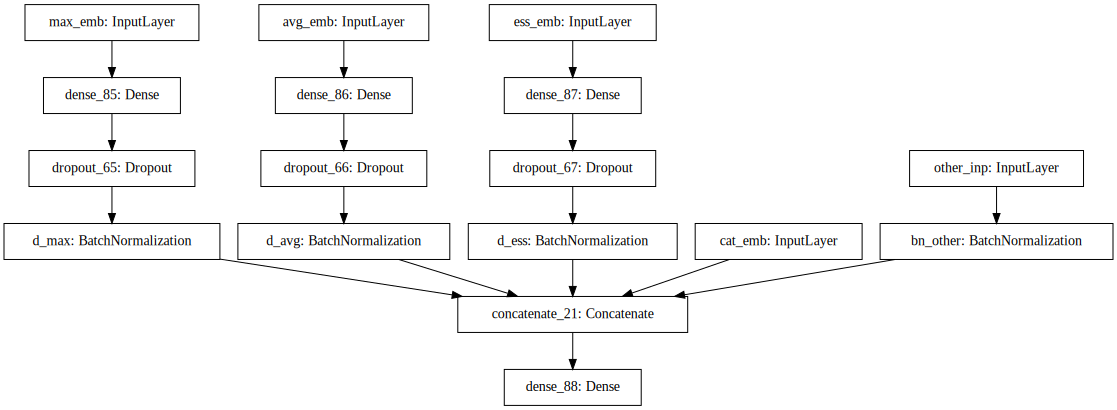

In [196]:
%load_ext autoreload
%autoreload 2
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train model

In [158]:
training_history = model.fit(x=train_data, y=target_var, batch_size=1000, epochs=50, validation_split=.2)

Train on 8824 samples, validate on 2206 samples
Epoch 1/50
8824/8824 [==============================] - 0s 29us/step - loss: 0.2628 - val_loss: 0.4286
Epoch 2/50
8824/8824 [==============================] - 0s 28us/step - loss: 0.2597 - val_loss: 0.4294
Epoch 3/50
8824/8824 [==============================] - 0s 28us/step - loss: 0.2595 - val_loss: 0.4299
Epoch 4/50
8824/8824 [==============================] - 0s 28us/step - loss: 0.2583 - val_loss: 0.4281
Epoch 5/50
8824/8824 [==============================] - 0s 28us/step - loss: 0.2559 - val_loss: 0.4279
Epoch 6/50
8824/8824 [==============================] - 0s 28us/step - loss: 0.2519 - val_loss: 0.4273
Epoch 7/50
8824/8824 [==============================] - 0s 28us/step - loss: 0.2531 - val_loss: 0.4288
Epoch 8/50
8824/8824 [==============================] - 0s 28us/step - loss: 0.2479 - val_loss: 0.4298
Epoch 9/50
8824/8824 [==============================] - 0s 28us/step - loss: 0.2461 - val_loss: 0.4288
Epoch 10/50
8824/8824 [==

## Score Model On Test Set

In [162]:
max_emb_dt = df[test_mask][[c for c in df.columns if c.startswith('max_emb_')]].values
avg_emb_dt = df[test_mask][[c for c in df.columns if c.startswith('mean_emb_')]].values
ess_emb_dt = df[test_mask][[c for c in df.columns if c.startswith('essay_emb_')]].values
cat_emb_dt = df[test_mask]['cat_essay_set'].values
other_dt = df[test_mask][['rs_fk_grade', 'rs_fk_ease', 'rs_ari', 'rs_cli', 'rs_dcrs']].values
target_var_test = df[test_mask]['normalized_score'].values

test_data = {'max_emb': max_emb_dt,
              'avg_emb': avg_emb_dt,
              'ess_emb': ess_emb_dt,
              'cat_emb': np.expand_dims(cat_emb_dt, -1),
              'other_inp': other_dt}

In [164]:
[print(f'{x}: ', test_data[x].shape) for x in test_data]

max_emb:  (1947, 512)
avg_emb:  (1947, 512)
ess_emb:  (1947, 512)
cat_emb:  (1947, 1)
other_inp:  (1947, 5)


[None, None, None, None, None]

In [166]:
test_predictions = model.predict(x=test_data, batch_size=500)

In [168]:
from sklearn.metrics import mean_squared_error

In [198]:
def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))

In [199]:
rmse(target_var_test, test_predictions)

0.6558999665191215

## Conclusion

This model achieves an RMSE of `.65` which is less accurate than the bsaeline models. 